# ScRNA-Seq of human pancreas cells


<br>Data from :
* CelSeq (GSE81076)
* CelSeq2 (GSE85241)
* Fluidigm C1 (GSE86469)
* SMART-Seq2 (E-MTAB-5061).
<br>
<br>
Can be downloaded from [Satija lab](https://satijalab.org/seurat/archive/v3.0/integration.html).

In [1]:
# Import packages
import scanpy as sc
import pandas as pd
from functions import data_preprocessing as dp

In [2]:
path = '../../../data/raw/pancreas_human/'
adata = sc.read_csv(filename = path + 'pancreas_human.csv').T
metadata = pd.read_csv((path + 'pancreas_human_meta.csv'), index_col=0)

#adata.obs['tech'] = metadata['tech'].values
adata.obs['patientID'] = ['PatientFromPancreasStudies']*adata.n_obs
adata.obs['cell_type_auther_annot'] = metadata['celltype'].values
adata.obs['study'] = ['PancreasCollection']*adata.n_obs
adata.obs['chemistry'] = metadata['tech'].values
adata.obs['tissue'] = ['Pancreas']*adata.n_obs
adata.obs['species'] = ['Human']*adata.n_obs
adata.obs['data_type'] = ['UMI']*adata.n_obs



In [3]:
adata.obs.index = adata.obs.index + ['-PancreasCollection']*adata.n_obs

In [4]:
print(adata.X.shape)
print(adata)

(6321, 34363)
AnnData object with n_obs × n_vars = 6321 × 34363
    obs: 'cell_type_auther_annot', 'study', 'chemistry', 'tissue', 'species', 'data_type'


In [5]:
adata.var.head()

""
A1BG-AS1
A1BG
A1CF
A2M-AS1
A2ML1


## Preprocessing

In [6]:
# Add QC metrics to adata
adata = dp.QC().QC_metric_calc(adata)
print(adata.obs)

                                    cell_type_auther_annot  \
D101_5-PancreasCollection                            gamma   
D101_43-PancreasCollection                           gamma   
D101_93-PancreasCollection                           gamma   
D102_4-PancreasCollection                            gamma   
D172444_23-PancreasCollection                        gamma   
...                                                    ...   
HP1504901_A22-PancreasCollection        quiescent_stellate   
HP1504901_M11-PancreasCollection        quiescent_stellate   
HP1504901_N21-PancreasCollection        quiescent_stellate   
HP1507101_P15-PancreasCollection        quiescent_stellate   
HP1508501T2D_M16-PancreasCollection     quiescent_stellate   

                                                  study  chemistry    tissue  \
D101_5-PancreasCollection            PancreasCollection     celseq  Pancreas   
D101_43-PancreasCollection           PancreasCollection     celseq  Pancreas   
D101_93-Pancrea

In [7]:
qc_adata = dp.QC().QC_filter_outliers(adata,[5,5,5])

Number of cells before QC filtering: 6321
Number of cells removed by log_n_genes filtering: 0
Number of cells removed by log_n_counts filtering: 0
Number of cells removed by pct_counts_in_top_20_genes filtering: 8
Number of cells post QC filtering: 6313
Number of genes before filtering: 34363
Number of genes after filtering so theres min 20 unique cells per gene: 22127


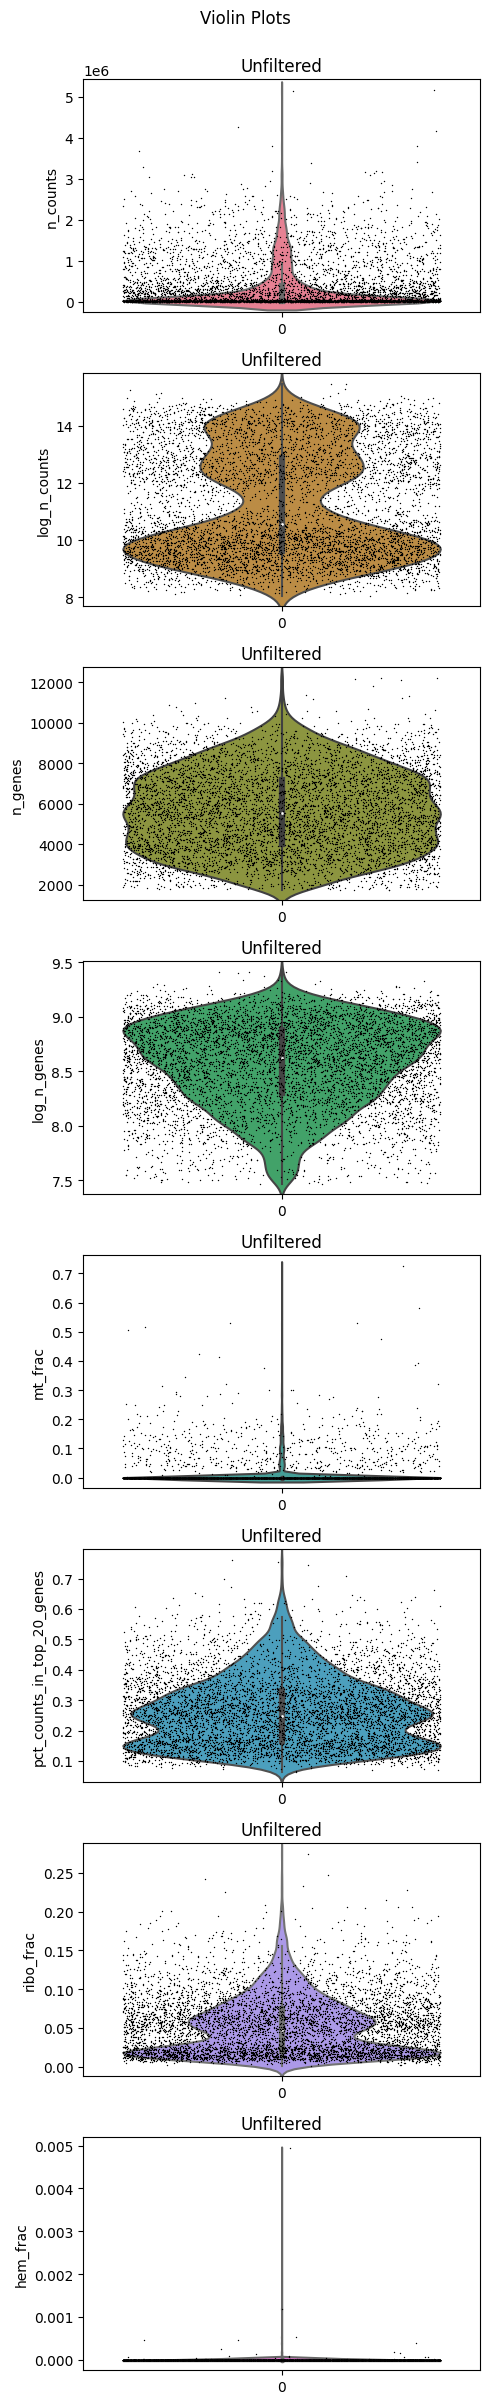

In [8]:
dp.EDA().ViolinJitter([adata], 
                        y_rows=['n_counts','log_n_counts','n_genes','log_n_genes','mt_frac','pct_counts_in_top_20_genes','ribo_frac','hem_frac'], 
                        title="Violin Plots",
                        subtitle=["Unfiltered"])

## Normalize

In [9]:
norm_qc_adata = dp.log1p_normalize(qc_adata)

In [10]:
norm_qc_adata

AnnData object with n_obs × n_vars = 6313 × 22127
    obs: 'cell_type_auther_annot', 'study', 'chemistry', 'tissue', 'species', 'data_type', 'n_counts', 'log_n_counts', 'n_genes', 'log_n_genes', 'pct_counts_in_top_20_genes', 'mt_frac', 'ribo_frac', 'hem_frac', 'outlier', 'size_factors'
    var: 'n_cells'
    layers: 'pp_counts', 'log1p_counts'

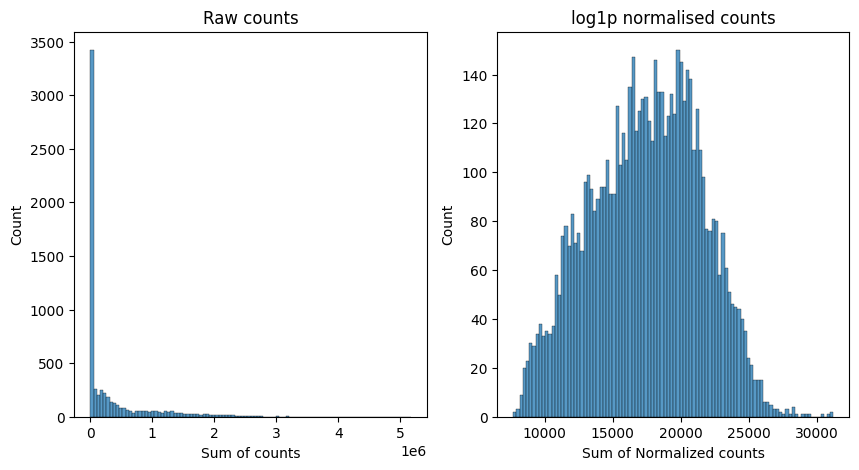

In [11]:
# Visualize counts before and after normalization
dp.EDA().VisualizeNormalization(norm_qc_adata)

In [12]:
# Download normalized count matrix
sc.pp.highly_variable_genes(norm_qc_adata, n_top_genes=4000, flavor="cell_ranger")
HVG_data = norm_qc_adata[:, norm_qc_adata.var["highly_variable"]]
normalized_counts = pd.DataFrame(HVG_data.layers["log1p_counts"])
normalized_counts.index = HVG_data.obs.index.to_list()
normalized_counts.columns = HVG_data.var.index.to_list()
normalized_counts.to_csv("pancreas_1.csv")
norm_qc_adata.write("pancreas_1_adata.h5ad")